Problem: heat losses depend on current state of charge of the storage vessel; how large error is made when a fixed percentage is assumed? Fixed heat loss value?

Possible solution: make the losses for a certain representative period equal to that based on the average SoC for that period ==> i.e. the mean between beginning and end state. This is of course not the true average value, depending on the actual profile lying in between. 

In [1]:
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

## Select representative periods 

How many? How long?

Integrate season and period selection into this script on longer term. For now, suffise with solution dictionary from separate script for debugging.

In [2]:
from collections import OrderedDict

selection = OrderedDict([(32, 11.0), (108, 12.0), (166, 15.0), (279, 11.0), (357, 3.0)])

## Set up optimization 

### Duration parameters

In [3]:
duration_repr = 7      # Week duration
unit_sec = 3600 * 24   # Seconds per unit time of duration (seconds per day)

### Network set-up

In [4]:
import networkx as nx

netGraph = nx.DiGraph()
netGraph.add_node('Node', x=0, y=0, z=0, comps={
    'backup': 'ProducerVariable',
    'storage': 'StorageVariable',
    'solar': 'SolarThermalCollector',
    'demand': 'BuildingFixed'
})

#### Storage and solar panel parameters 

In [5]:
storVol = 75000
solArea = 2*(18300+ 15000)
backupPow = 1.3*3.85e6  # +10% of actual peak boiler power

#### External data 

In [6]:
import modesto.utils as ut
from pkg_resources import resource_filename
import pandas as pd

In [7]:
DATAPATH = resource_filename('modesto', 'Data')

In [8]:
dem = ut.read_time_data(path=DATAPATH, 
                        name='HeatDemand/Initialized/HeatDemandFiltered.csv')

dem = dem['TermienWest']

In [9]:
t_amb = ut.read_time_data(DATAPATH, name='Weather/extT.csv')
t_g = pd.Series(12 + 273.15, index=t_amb.index)

general_params = {'Te': t_amb['Te'],
                  'Tg': t_g}

In [10]:
c_f = pd.Series(20/1000, index=t_amb.index)
# ut.read_period_data(path='../Data/Weather',
#                    name='extT.txt')

### Optimization code

In [11]:
from modesto.main import Modesto
from pyomo.core.base import ConcreteModel, Set, Objective, Param, Constraint, minimize
from pyomo.environ import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

01-15 16:16 pyutilib.component.core.pca          DEBUG    Creating PluginEnvironment 'pca'
01-15 16:16 pyutilib.component.core.pca          DEBUG    Pushing environment 'pca' on the PluginGlobals stack
01-15 16:16 pyutilib.component.core.pca          DEBUG    Pushing environment 'pca' on the PluginGlobals stack
01-15 16:16 pyutilib.component.core.pca          DEBUG    Pushing environment 'pca' on the PluginGlobals stack
01-15 16:16 pyutilib.component.core.pca          DEBUG    Popping environment 'pca' from the PluginGlobals stack
01-15 16:16 pyutilib.component.core.pca          DEBUG    Popping environment 'pca' from the PluginGlobals stack
01-15 16:16 pyutilib.component.core.pca          DEBUG    Pushing environment 'pca' on the PluginGlobals stack


In [12]:
import time

begin = time.time()
topmodel = ConcreteModel()

In [13]:
optimizers = {}
epoch = pd.Timestamp('20140101')
for start_day, duration in selection.iteritems():
    start_time = epoch + pd.Timedelta(days=start_day)
    optmodel = Modesto(horizon=duration_repr * unit_sec, time_step=3600, start_time=start_time, 
                       graph=netGraph, pipe_model='SimplePipe')
    topmodel.add_component(name='repr_'+str(start_day), val=optmodel.model)
    
    #####################
    # Assign parameters #
    #####################
    
    optmodel.change_params(general_params)
    
    optmodel.change_params({'delta_T': 40,
                            'mult': 1,
                            'heat_profile': dem}, 
                           node='Node', comp='demand')
    
    optmodel.change_params({# Thi and Tlo need to be compatible with delta_T of previous
                        'Thi': 80 + 273.15,
                        'Tlo': 40 + 273.15,
                        'mflo_max': 11000000,
                        'volume': storVol,
                        'ar': 0.18,
                        'dIns': 0.15,
                        'kIns': 0.024,
                        'heat_stor': 0
                       }, node='Node', comp='storage')
    optmodel.change_init_type('heat_stor', 'free', node='Node', comp='storage')
    
    prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               # http://ec.europa.eu/eurostat/statistics-explained/index.php/Energy_price_statistics (euro/kWh CH4)
               'Qmax': backupPow,
               'ramp_cost': 0.00,
               'ramp': 10e8 / 3600}
    
    optmodel.change_params(prod_design, node='Node', comp='backup')
    
    optmodel.change_params({'area': solArea, 'delta_T':40}, node='Node', comp='solar')
    
    ####################
    # Compile problems #
    ####################
    
    optmodel.compile()
    #optmodel.set_objective('energy')
    
    optimizers[start_day] = optmodel

01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Te
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
01-15 16:16 modesto.Node                         INFO     Initializing Node Node
01-15 16:16 modesto.component.Component          INFO     Initializing Component storage
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Thi
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tlo
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_max
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter volume
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter ar
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter dIns
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter kIns
01-15 16:16 modesto.parameter.Parameter          INFO     

01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Te
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
01-15 16:16 modesto.Node                         INFO     Initializing Node Node
01-15 16:16 modesto.component.Component          INFO     Initializing Component storage
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Thi
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tlo
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_max
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter volume
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter ar
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter dIns
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter kIns
01-15 16:16 modesto.parameter.Parameter          INFO     

01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Te
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
01-15 16:16 modesto.Node                         INFO     Initializing Node Node
01-15 16:16 modesto.component.Component          INFO     Initializing Component storage
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Thi
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter Tlo
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter mflo_max
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter volume
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter ar
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter dIns
01-15 16:16 modesto.parameter.Parameter          INFO     Initializing Parameter kIns
01-15 16:16 modesto.parameter.Parameter          INFO     

In [14]:
##############################
# Compile aggregated problem #
##############################

selected_days = selection.keys()

for i, next_day in enumerate(selected_days):
    current = selected_days[i-1]
    
    next_init = optimizers[next_day].get_heat_stor_init()
    
    current_init = optimizers[current].get_heat_stor_init()
    current_final = optimizers[current].get_heat_stor_final()
    
    for component_id in next_init:
        def _link_stor(m):
            return next_init[component_id] == current_init[component_id] + selection[current] * (current_final[component_id] - current_init[component_id])
        topmodel.add_component(name='_'.join([component_id, str(current)]), val=Constraint(rule=_link_stor))
        print 'Constraint added for storage {} in representative week starting on day {}'.format(component_id, current)

Constraint added for storage Node.storage in representative week starting on day 357
Constraint added for storage Node.storage in representative week starting on day 32
Constraint added for storage Node.storage in representative week starting on day 108
Constraint added for storage Node.storage in representative week starting on day 166
Constraint added for storage Node.storage in representative week starting on day 279


In [15]:
def _top_objective(m):
    return sum(opt.get_objective(objtype='energy', get_value=False) for opt in optimizers.values())

# set get_value to False to return object instead of value of the objective function
topmodel.obj = Objective(rule=_top_objective, sense=minimize)

In [16]:
end = time.time()

print 'Writing time:', str(end-begin)

Writing time: 1.59200000763


In [18]:
begin = time.time()
opt = SolverFactory("gurobi")
# opt.options["Threads"] = threads
# opt.options["MIPGap"] = mipgap
results = opt.solve(topmodel, tee=True)
    
end = time.time()

print 'Solving time:', str(end-begin)

Academic license - for non-commercial use only
Optimize a model with 11766 rows, 9251 columns and 23526 nonzeros
Coefficient statistics:
  Matrix range     [6e-06, 2e+05]
  Objective range  [1e-03, 1e+00]
  Bounds range     [5e+06, 2e+12]
  RHS range        [5e-06, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 11174 rows and 7768 columns
Presolve time: 0.01s
Presolved: 592 rows, 1483 columns, 2080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3286082e-11   1.715754e+06   0.000000e+00      0s
     450    1.5520964e+06   0.000000e+00   0.000000e+00      0s

Solved in 450 iterations and 0.03 seconds
Optimal objective  1.552096387e+06
Solving time: 0.74599981308


In [17]:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    status = 0
elif results.solver.termination_condition == TerminationCondition.infeasible:
    status = 1
    print 'Model is infeasible'
else:
    status = -1
    print 'Solver status: ', results.solver.status

NameError: name 'results' is not defined

## Post-processing

In [17]:
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


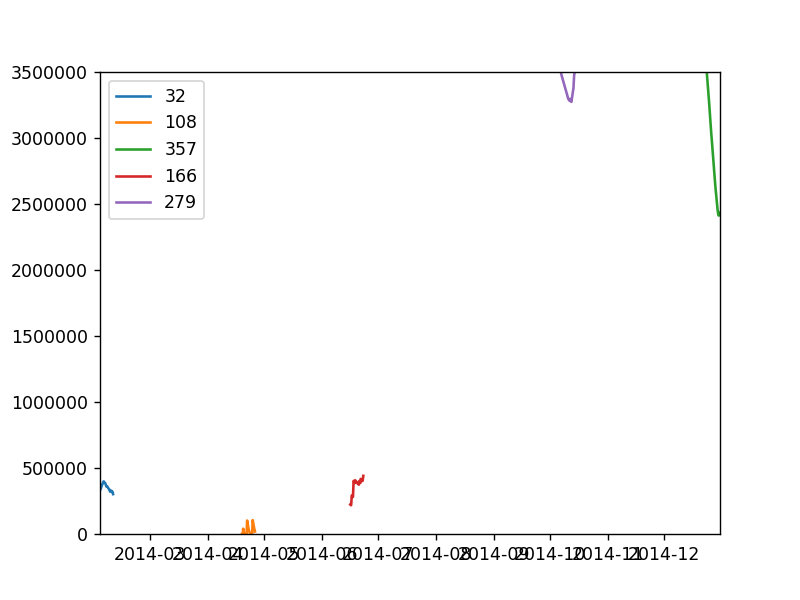

In [19]:
fig, ax = plt.subplots()
for startday, opt in optimizers.iteritems():
    res = opt.get_result('heat_stor', node='Node', comp='storage', check_results=False)
    ax.plot(res, label=startday)

ax.legend()

In [ ]:
selection = OrderedDict([(32, 11.0), (108, 12.0), (166, 15.0), (279, 11.0), (357, 3.0)])

In [ ]:
opt=optimizers[optimizers.keys()[0]]

In [ ]:
from pyomo.core.base import value

for i in opt.model.Node.storage.heat_stor:
    print value(opt.model.Node.storage.heat_stor[i])